## Overview

This project will analyze historical sales data to determine price elasticity of demand and recommend optimal pricing strategies to maximize revenue. We'll use statistical modeling to understand how demand varies with price and simulate revenue under different pricing scenarios. 

In [4]:
#  Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [5]:
# Load and Preview Data
df = pd.read_csv("retail_sales_dataset.csv")  
df['Date'] = pd.to_datetime(df['Date'])  # Converting date to datetime

df.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


### Data Cleaning

In [3]:
# Checking for nulls
print(df.isnull().sum())

# Ensuring numeric fields are numeric
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price per Unit'] = pd.to_numeric(df['Price per Unit'], errors='coerce')

Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64


### Feature Engineering

In [7]:
# Grouping by Product Category and Date
agg_df = df.groupby(['Product Category', df['Date'].dt.to_period('M')]).agg({
    'Quantity': 'sum',
    'Price per Unit': 'mean'
}).reset_index()

agg_df['Date'] = agg_df['Date'].dt.to_timestamp()

## Demand Elasticity Analysis

In [8]:
# Elasticity Estimation (Log-Log Model)
agg_df = agg_df[agg_df['Quantity'] > 0]  # Avoid log(0)
agg_df['log_Q'] = np.log(agg_df['Quantity'])
agg_df['log_P'] = np.log(agg_df['Price per Unit'])

# Run regression per product category
elasticities = []

for cat in agg_df['Product Category'].unique():
    sub = agg_df[agg_df['Product Category'] == cat]
    X = sm.add_constant(sub['log_P'])
    model = sm.OLS(sub['log_Q'], X).fit()
    elasticity = model.params['log_P']
    elasticities.append({'Category': cat, 'Elasticity': elasticity})

elasticity_df = pd.DataFrame(elasticities)
print(elasticity_df)

      Category  Elasticity
0       Beauty   -1.858006
1     Clothing   -0.728638
2  Electronics    2.161707


### Visualizing Price-Demand Relationship

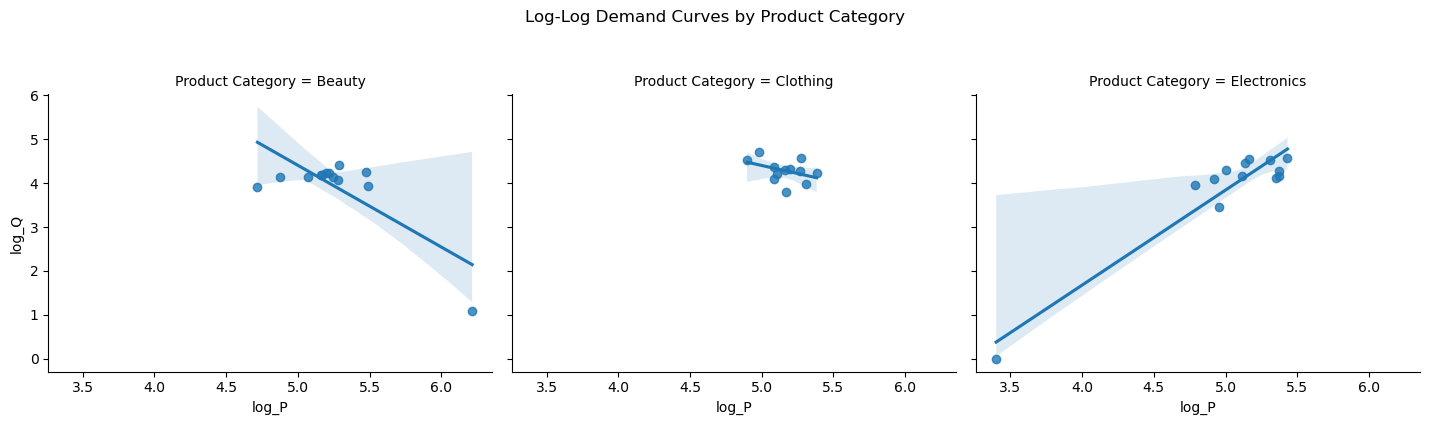

In [9]:
sns.lmplot(data=agg_df, x='log_P', y='log_Q', col='Product Category', aspect=1.2, height=4)
plt.suptitle("Log-Log Demand Curves by Product Category", y=1.05)
plt.tight_layout()

## Revenue Simulation

In [10]:
# Simulating revenue under price changes
def simulate_revenue(df, category, price_multiplier):
    cat_df = df[df['Product Category'] == category].copy()
    cat_df['New_Price'] = cat_df['Price per Unit'] * price_multiplier
    cat_df['New_Quantity'] = cat_df['Quantity'] * (price_multiplier ** elasticity_df[elasticity_df['Category'] == category]['Elasticity'].values[0])
    cat_df['New_Revenue'] = cat_df['New_Price'] * cat_df['New_Quantity']
    return cat_df[['Date', 'Product Category', 'New_Price', 'New_Quantity', 'New_Revenue']]

sim_125 = simulate_revenue(agg_df, 'Electronics', 1.25)
sim_125.head()

,Date,Product Category,New_Price,New_Quantity,New_Revenue
25,2023-01-01,Electronics,208.000000,103.674273,21564.248886
26,2023-02-01,Electronics,268.750000,115.013647,30909.917672
27,2023-03-01,Electronics,176.785714,51.837137,9164.065246
28,2023-04-01,Electronics,150.297619,84.235347,12660.372125
29,2023-05-01,Electronics,285.625000,157.131321,44880.633491


In [11]:
# Exporting Results
agg_df.to_csv('price_demand_data.csv', index=False)
elasticity_df.to_csv('elasticity_by_category.csv', index=False)


## Price Optimization using Elasticityy

In [12]:
def estimate_demand_coefficient(df, category):
    sub = df[df['Product Category'] == category]
    sub = sub[sub['Quantity'] > 0]
    sub['log_Q'] = np.log(sub['Quantity'])
    sub['log_P'] = np.log(sub['Price per Unit'])

    X = sm.add_constant(sub['log_P'])
    model = sm.OLS(sub['log_Q'], X).fit()
    intercept = model.params['const']
    elasticity = model.params['log_P']

    a = np.exp(intercept)
    return a, elasticity


In [13]:
def simulate_optimal_price(a, elasticity, price_range):
    prices = np.linspace(price_range[0], price_range[1], 100)
    quantities = a * prices ** elasticity
    revenues = prices * quantities

    # Optimal Price
    idx = np.argmax(revenues)
    optimal_price = prices[idx]
    max_revenue = revenues[idx]

    return prices, revenues, optimal_price, max_revenue


### Example Scenario : "Clothing"

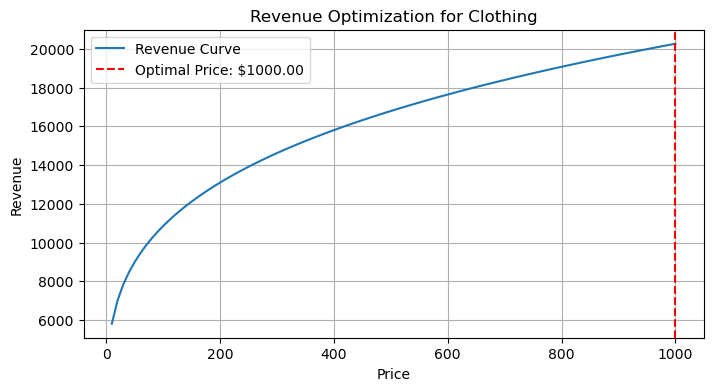

In [14]:
# Example Usage
category = "Clothing"
a, elasticity = estimate_demand_coefficient(agg_df, category)
prices, revenues, opt_price, max_rev = simulate_optimal_price(a, elasticity, price_range=(10, 1000))

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(prices, revenues, label="Revenue Curve")
plt.axvline(opt_price, color='red', linestyle='--', label=f"Optimal Price: ${opt_price:.2f}")
plt.title(f"Revenue Optimization for {category}")
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()


Exporting Simulation results

In [15]:
opt_df = pd.DataFrame({
    'Price': prices,
    'Revenue': revenues
})
opt_df.to_csv('price_optimization_results.csv', index=False)

## Running Simulation per Category

In [19]:
def estimate_demand_params(df, category):
    """
    Estimate demand curve parameters a and elasticity for a specific product category.
    Returns (a, elasticity) for use in simulation.
    """
    subset = df[df['Product Category'] == category].copy()
    subset = subset[(subset['Quantity'] > 0) & (subset['Price per Unit'] > 0)]
    subset['log_Q'] = np.log(subset['Quantity'])
    subset['log_P'] = np.log(subset['Price per Unit'])

    X = sm.add_constant(subset['log_P'])
    model = sm.OLS(subset['log_Q'], X).fit()

    intercept = model.params['const']
    elasticity = model.params['log_P']
    a = np.exp(intercept)

    return a, elasticity, model.rsquared


### Elasticity Estimation Function

In [18]:
def simulate_optimal_price(a, elasticity, price_range=(10, 1000)):
    prices = np.linspace(price_range[0], price_range[1], 200)
    quantities = a * prices ** elasticity
    revenues = prices * quantities

    idx = np.argmax(revenues)
    optimal_price = prices[idx]
    max_revenue = revenues[idx]

    return prices, revenues, optimal_price, max_revenue


In [16]:
def run_price_optimization(df, category, price_range=(10, 1000)):
    print(f"\n🔍 Running Price Optimization for: {category}")
    a, elasticity, r2 = estimate_demand_params(df, category)
    print(f"Estimated Elasticity: {elasticity:.2f}")
    print(f"Model R²: {r2:.2f}")
    
    prices, revenues, opt_price, max_rev = simulate_optimal_price(a, elasticity, price_range)
    print(f"✅ Optimal Price: ${opt_price:.2f}")
    print(f"💰 Max Revenue: ${max_rev:,.2f}")
    
    plot_revenue_curve(prices, revenues, opt_price, category)

### Visualization Funciton

In [21]:
def plot_revenue_curve(prices, revenues, optimal_price, category):
    plt.figure(figsize=(8, 5))
    plt.plot(prices, revenues, label='Simulated Revenue')
    plt.axvline(optimal_price, color='red', linestyle='--', label=f'Optimal Price = ${optimal_price:.2f}')
    plt.title(f'Revenue Optimization Curve – {category}')
    plt.xlabel('Price')
    plt.ylabel('Revenue')
    plt.grid(True)
    plt.legend()
    plt.show()

### Scenario example 


🔍 Running Price Optimization for: Beauty
Estimated Elasticity: 0.02
Model R²: 0.00
✅ Optimal Price: $1000.00
💰 Max Revenue: $2,362.44


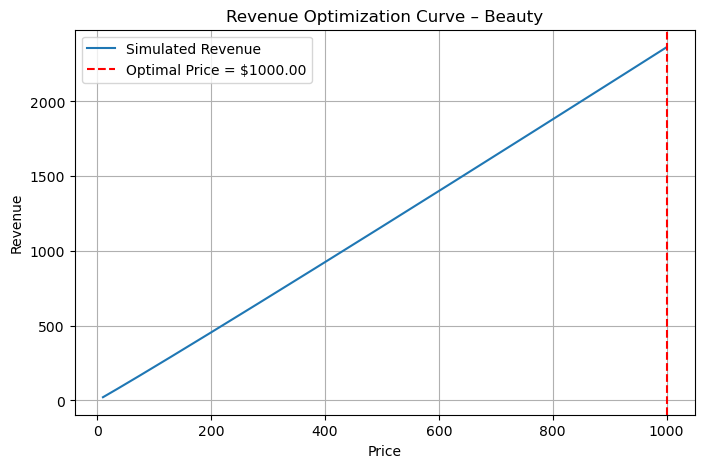


🔍 Running Price Optimization for: Clothing
Estimated Elasticity: 0.00
Model R²: 0.00
✅ Optimal Price: $1000.00
💰 Max Revenue: $2,267.82


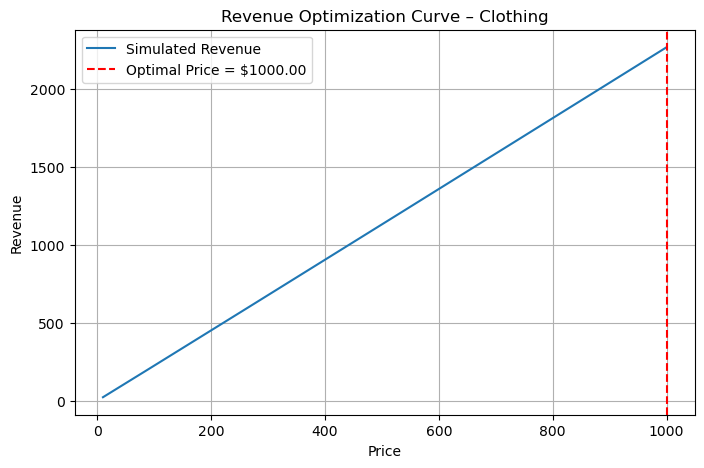


🔍 Running Price Optimization for: Electronics
Estimated Elasticity: 0.01
Model R²: 0.00
✅ Optimal Price: $1000.00
💰 Max Revenue: $2,239.98


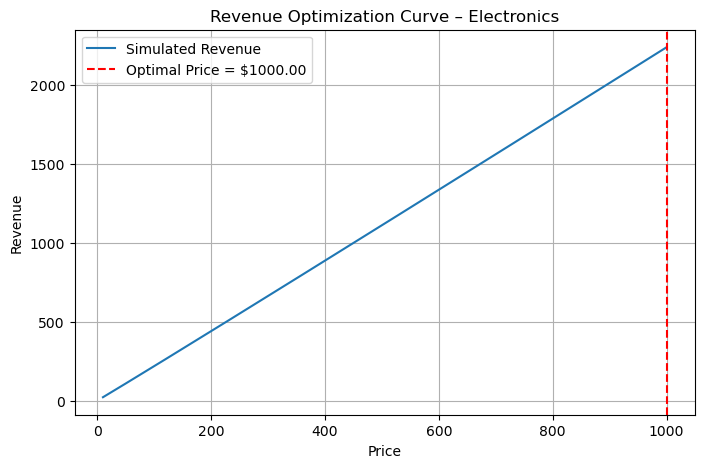

In [22]:
categories = df['Product Category'].unique()

for cat in categories:
    run_price_optimization(df, cat, price_range=(10, 1000))

The result tells that something is off here as the regression model is explaining NONE of the variance in quantity based on price. Further oinspection is required.

In [23]:
print(df[df['Product Category'] == 'Beauty'][['Price per Unit', 'Quantity']])

     Price per Unit  Quantity
0                50         3
4                50         2
5                30         1
11               25         3
20              500         1
..              ...       ...
981              30         3
989             500         2
993             500         2
996              30         3
997              25         4

[307 rows x 2 columns]


Thhis reveals the key issue:products like "Beauty" have some repeated prices (like 25, 30, 50, and 500) but many products share the same price, and the quantity doesn’t vary much either. We'll fix by using aggregated price-demand pairs.

In [24]:
def run_price_optimization_aggregated(df, category):
    # Filter the product category
    subset = df[df['Product Category'] == category]
    
    if subset.empty:
        print(f"No data for {category}")
        return

    # Aggregate: Average quantity per unique price
    agg = subset.groupby('Price per Unit')['Quantity'].mean().reset_index()
    agg.columns = ['Price', 'Avg_Quantity']
    
    # Log-transform
    agg = agg[agg['Price'] > 0]
    agg['log_P'] = np.log(agg['Price'])
    agg['log_Q'] = np.log(agg['Avg_Quantity'])

    # Run log-log regression
    X = sm.add_constant(agg['log_P'])
    y = agg['log_Q']
    model = sm.OLS(y, X).fit()
    
    elasticity = model.params['log_P']
    r2 = model.rsquared

    # Define demand function: Q = a * P^b
    a = np.exp(model.params['const'])
    b = elasticity

    # Simulate revenue over a range of prices
    price_range = np.linspace(agg['Price'].min(), agg['Price'].max(), 100)
    predicted_qty = a * price_range ** b
    revenue = price_range * predicted_qty

    optimal_index = np.argmax(revenue)
    optimal_price = price_range[optimal_index]
    max_revenue = revenue[optimal_index]

    # Output
    print(f"🔍 Running Price Optimization for: {category}")
    print(f"Estimated Elasticity: {elasticity:.2f}")
    print(f"Model R²: {r2:.2f}")
    print(f"✅ Optimal Price: ${optimal_price:.2f}")
    print(f"💰 Max Revenue: ${max_revenue:,.2f}")

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(price_range, revenue, color='green', label='Revenue Curve')
    plt.axvline(optimal_price, color='red', linestyle='--', label=f'Optimal Price: ${optimal_price:.2f}')
    plt.title(f"{category} - Price Optimization")
    plt.xlabel("Price")
    plt.ylabel("Revenue")
    plt.legend()
    plt.grid(True)
    plt.show()

### Running the Aggregated Optimization

🔍 Running Price Optimization for: Beauty
Estimated Elasticity: 0.02
Model R²: 0.27
✅ Optimal Price: $500.00
💰 Max Revenue: $1,292.21


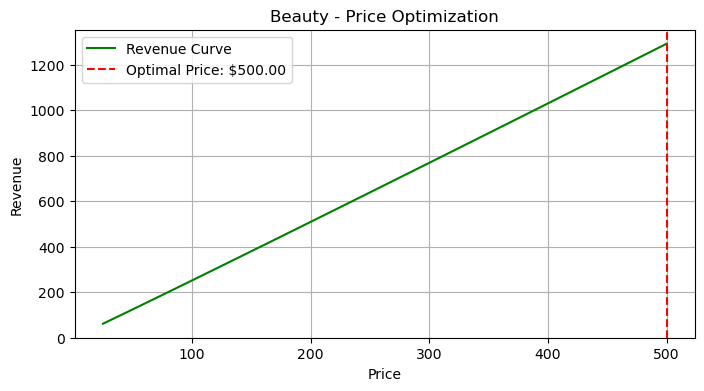

In [28]:
run_price_optimization_aggregated(df, 'Beauty')

🔍 Running Price Optimization for: Beauty
Estimated Elasticity: 0.02
Model R²: 0.27
✅ Optimal Price: $500.00
💰 Max Revenue: $1,292.21


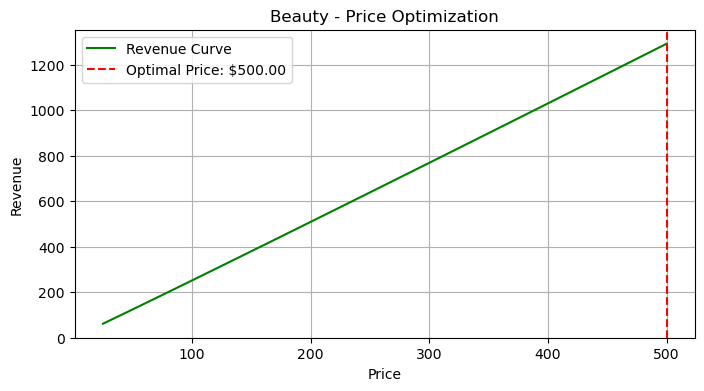

🔍 Running Price Optimization for: Clothing
Estimated Elasticity: 0.00
Model R²: 0.01
✅ Optimal Price: $500.00
💰 Max Revenue: $1,277.53


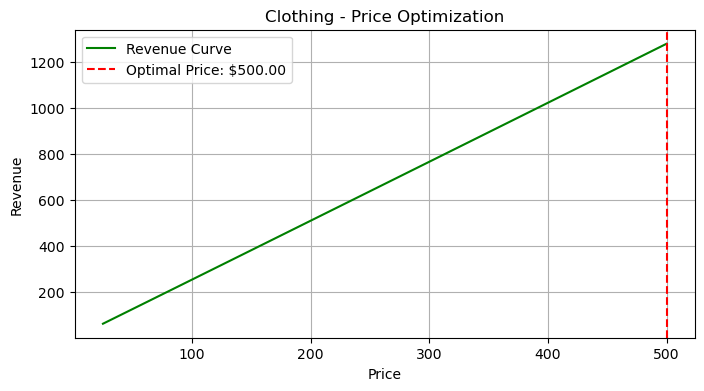

🔍 Running Price Optimization for: Electronics
Estimated Elasticity: 0.02
Model R²: 0.22
✅ Optimal Price: $500.00
💰 Max Revenue: $1,272.89


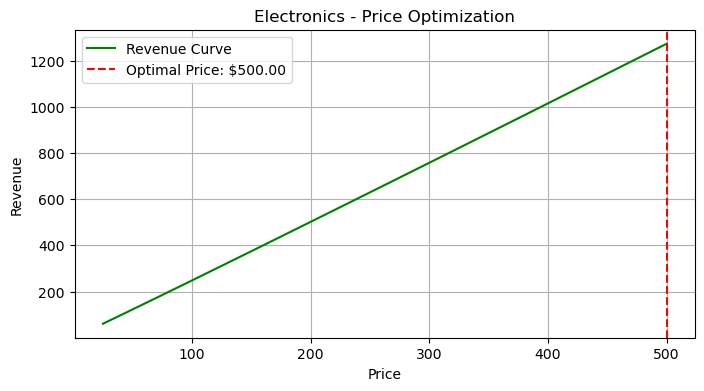

In [32]:
for cat in df['Product Category'].unique():
    run_price_optimization_aggregated(df, cat)


In [31]:
#Exporting results
results = []

for cat in df['Product Category'].unique():
    subset = df[df['Product Category'] == cat]
    if subset.empty: continue

    agg = subset.groupby('Price per Unit')['Quantity'].mean().reset_index()
    agg.columns = ['Price', 'Avg_Quantity']
    agg = agg[agg['Price'] > 0]
    agg['log_P'] = np.log(agg['Price'])
    agg['log_Q'] = np.log(agg['Avg_Quantity'])

    X = sm.add_constant(agg['log_P'])
    y = agg['log_Q']
    model = sm.OLS(y, X).fit()

    elasticity = model.params['log_P']
    r2 = model.rsquared
    a = np.exp(model.params['const'])
    b = elasticity

    price_range = np.linspace(agg['Price'].min(), agg['Price'].max(), 100)
    predicted_qty = a * price_range ** b
    revenue = price_range * predicted_qty
    optimal_price = price_range[np.argmax(revenue)]
    max_revenue = np.max(revenue)

    results.append({
        'Category': cat,
        'Elasticity': round(elasticity, 2),
        'R2': round(r2, 2),
        'Optimal Price': round(optimal_price, 2),
        'Max Revenue': round(max_revenue, 2)
    })

# Saving to CSV
pd.DataFrame(results).to_csv('price_optimization_summary.csv', index=False)
